In [126]:
import karhunenLoeve as kl
from matplotlib import pyplot as plt
from matplotlib import colormaps
from matplotlib import colors
from matplotlib.ticker import MaxNLocator
import numpy as np
import time
from scipy.special import kv, gamma
from  scipy.optimize import brentq

import graphSettings

testing of integrals in the Galerkin Method for Spectral Decomposition

## 1D
#### Calculation of W matrix
should be identity matrix due to orthogonality

[[ 1.00000000e+00  7.07767178e-16 -4.59875193e-15  5.29784550e-15]
 [ 7.07767178e-16  1.00000000e+00  5.26510259e-15 -5.97178557e-15]
 [-4.59875193e-15  5.26510259e-15  1.00000000e+00  5.12263842e-15]
 [ 5.29784550e-15 -5.97178557e-15  5.12263842e-15  1.00000000e+00]]


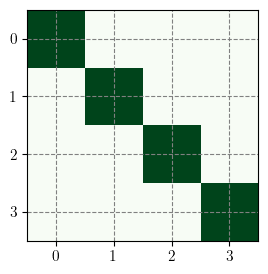

In [35]:

l = lambda x : kl.integ.legendre_normal(x, 100)

matrix_size = 4
matrix = np.zeros((matrix_size,matrix_size))
for i in range(matrix_size):
    for j in range(matrix_size):
        matrix[i,j] = kl.integ.quadrature(lambda x : l(x)[i]*l(x)[j], 100)
print(matrix)

# plot
fig, ax = plt.subplots()


ax.imshow(matrix, cmap=colormaps['Greens'])
plt.show()

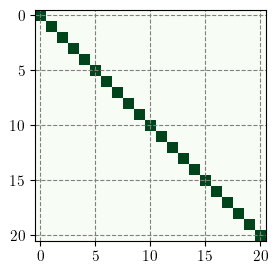

In [36]:
l = lambda x : kl.integ.legendre_normal(x, 20)

n = 50


nodes, weights = kl.integ.nodes_weights(n)

values = l(nodes)


matrix = ((values * weights) @ values.T)
#print(values)
#print(values * weights)


# plot
fig, ax = plt.subplots()

ax.imshow(matrix, cmap=colormaps['Greens'])
plt.show()


with interval <a,b>:

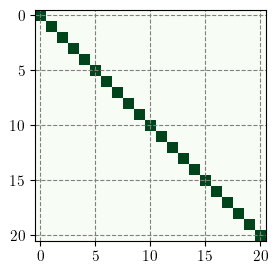

In [37]:
a = 0
b = 5
l = lambda x : kl.integ.legendre_normal(((a+b)/(a-b) + (2/(b-a))*x), 20)

n = 50


nodes, weights = kl.integ.nodes_weights(n)

nodes = (a+b)/2 + (b-a)/2*nodes
weights = weights * (b-a)/2

values = l(nodes)


matrix = ((values * weights) @ values.T)
#print(values)
#print(values * weights)

# plot
fig, ax = plt.subplots()

ax.imshow(matrix, cmap=colormaps['Greens'])
plt.show()

## Covariance function

(copied:)

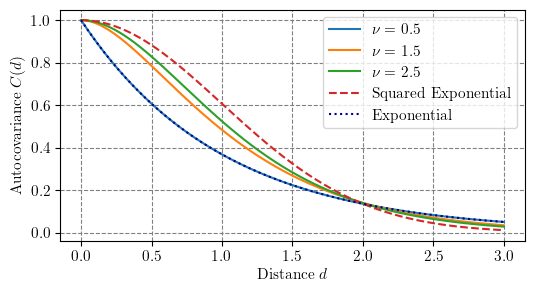

In [84]:
# Define parameters
length_scale = 1.0
variance = 1.0
distances = np.linspace(0, 3, 500)

# Define Matérn covariance function
def matern_covariance(d, l, sigma2, nu):
    if np.any(d < 0):
        raise ValueError("Distance d cannot be negative.")
    
    d_safe = np.where(d == 0, 1e-10, d) # Use a small epsilon instead of 0
    const_part = sigma2 * (2**(1 - nu)) / gamma(nu)
    scaled_dist = np.sqrt(2 * nu) * d_safe / l
    bessel_part = kv(nu, scaled_dist)
    
    cov = const_part * (scaled_dist**nu) * bessel_part
    
    cov[d == 0] = sigma2 
    
    if nu == 0.5:
        cov = sigma2 * np.exp(-d / l)
    elif nu == 1.5:
        cov = sigma2 * (1 + np.sqrt(3) * d / l) * np.exp(-np.sqrt(3) * d / l)
    elif nu == 2.5:
        cov = sigma2 * (1 + np.sqrt(5) * d / l + 5 * d**2 / (3 * l**2)) * np.exp(-np.sqrt(5) * d / l)
        
    return cov

# Smoothness parameters to plot
nus = [0.5, 1.5, 2.5]

for nu in nus:
    cov = matern_covariance(distances, length_scale, variance, nu)
    plt.plot(distances, cov, label=f'$\\nu = {nu}$')

# Calculate Squared Exponential (Gaussian) covariance
sq_exp_cov = variance * np.exp(-(distances**2) / (2 * length_scale**2))
plt.plot(distances, sq_exp_cov, label='Squared Exponential', linestyle='--')

# Calculate Exponential covariance
exp_cov = variance * np.exp(-distances / length_scale)
plt.plot(distances, exp_cov, label='Exponential', linestyle=':', color="darkblue")

#plt.title('Covariance Functions ($l=1, \\sigma^2=1$)')
plt.xlabel('Distance $d$')
plt.ylabel('Autocovariance $C(d)$')
plt.legend()
plt.savefig("CovarienceFunctions.pdf", bbox_inches='tight')
plt.show()

### Intagral with Covariance funtion

In [257]:
l = lambda x : kl.integ.legendre_normal(x, 60)
cov = lambda x,y : np.exp(-np.abs(x-y))

#dist_sq = x**2 + y**2
#dist = np.sqrt(dist_sq) = np.sqrt(x**2 + y**2)
length_scale = 1.0
exp_cov = lambda x,y : variance * np.exp(-np.abs(x-y) / length_scale)
sq_exp_cov = lambda x,y : variance * np.exp(-(np.abs(x-y))**2 / (2 * length_scale**2))
mat_cov = lambda x,y : matern_covariance(np.abs(x-y), length_scale, variance, 2.5)

#### Matrix $A$ calculation from different Covarience functions:

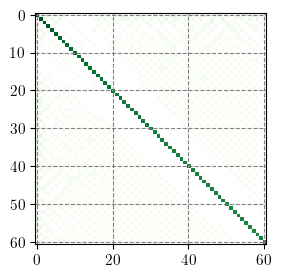

In [258]:
n = 1000

nodes, weights = kl.integ.nodes_weights(n)

nodesx, nodesy = np.meshgrid(nodes,nodes)
values = l(nodes)
#print(cov(nodesx, nodesy))

PW = (values * weights)
exp_matrix = PW @ (exp_cov(nodesx, nodesy) )@ PW.T
#print(matrix)

# plot
fig, ax = plt.subplots()

#ax.imshow(matrix, cmap=colormaps['Greens'])
ax.imshow(exp_matrix, cmap=colormaps['Greens'], norm=colors.LogNorm())
plt.show()

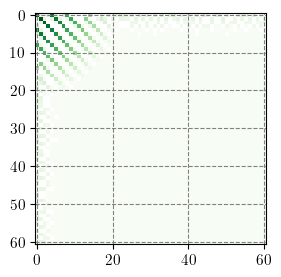

In [259]:
n = 1000

nodes, weights = kl.integ.nodes_weights(n)

nodesx, nodesy = np.meshgrid(nodes,nodes)
values = l(nodes)

#print(cov(nodesx, nodesy))

PW = (values * weights)
sq_exp_matrix = PW @ (sq_exp_cov(nodesx, nodesy) )@ PW.T
#print(matrix)

# plot
fig, ax = plt.subplots()

#ax.imshow(matrix, cmap=colormaps['Greens'])
ax.imshow(sq_exp_matrix, cmap=colormaps['Greens'], norm=colors.LogNorm())
plt.show()

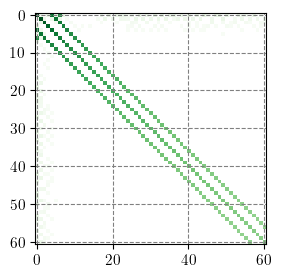

In [260]:
n = 1000

nodes, weights = kl.integ.nodes_weights(n)

nodesx, nodesy = np.meshgrid(nodes,nodes)
values = l(nodes)

#print(cov(nodesx, nodesy))

PW = (values * weights)
mat_matrix = PW @ (mat_cov(nodesx, nodesy) )@ PW.T
#print(matrix)

# plot
fig, ax = plt.subplots()

#ax.imshow(matrix, cmap=colormaps['Greens'])
ax.imshow(mat_matrix, cmap=colormaps['Greens'], norm=colors.LogNorm())
plt.show()

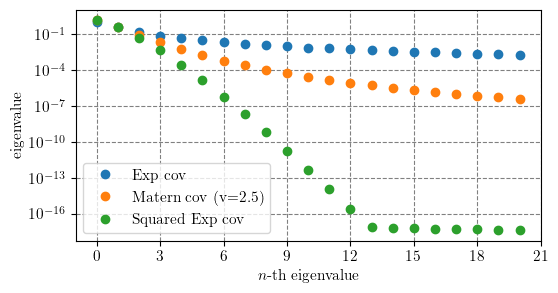

In [270]:
x_axis = np.linspace(-1, 1, 1000)
values = l(x_axis)

# eigendecomposition of exp_matrix
exp_eigenvalues, exp_eigenvectors = np.linalg.eigh(exp_matrix)
exp_eigenvectors_functions = (values.T @ exp_eigenvectors) * np.sqrt(np.maximum(exp_eigenvalues, 0))

# eigendecomposition of sq_exp_matrix
sqexp_eigenvalues, sqexp_eigenvectors = np.linalg.eigh(sq_exp_matrix)
sqexp_eigenvectors_functions = (values.T @ sqexp_eigenvectors) * np.sqrt(np.maximum(sqexp_eigenvalues, 0))

# eigendecomposition of mat_matrix
mat_eigenvalues, mat_eigenvectors = np.linalg.eigh(mat_matrix)
mat_eigenvectors_functions = (values.T @ mat_eigenvectors) * np.sqrt(np.maximum(mat_eigenvalues, 0))

fig, ax = plt.subplots()
ax.plot(exp_eigenvalues[:-22:-1], 'o', label='Exp cov')
ax.plot(mat_eigenvalues[:-22:-1], 'o', label='Matern cov (v=2.5)')
ax.plot(sqexp_eigenvalues[:-22:-1], 'o', label='Squared Exp cov')
ax.set_yscale("log")
ax.set_xlabel('$n$-th eigenvalue')
ax.set_ylabel('eigenvalue')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.savefig("eigenvalues.pdf", bbox_inches='tight')
plt.show()

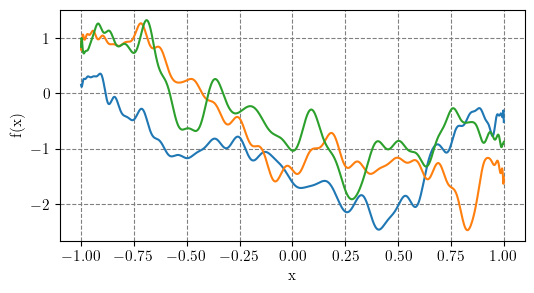

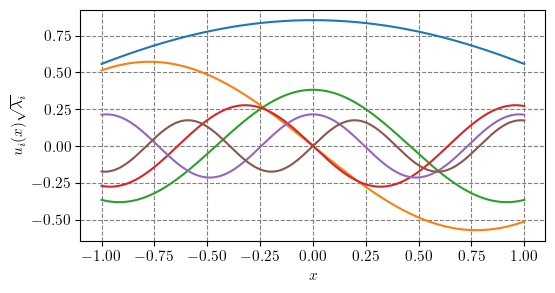

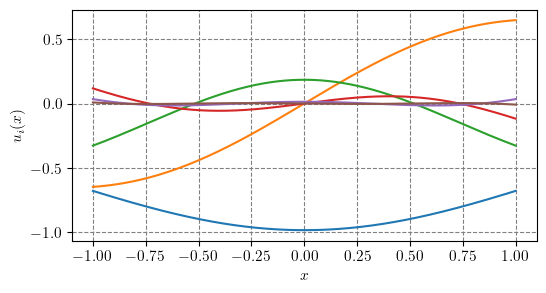

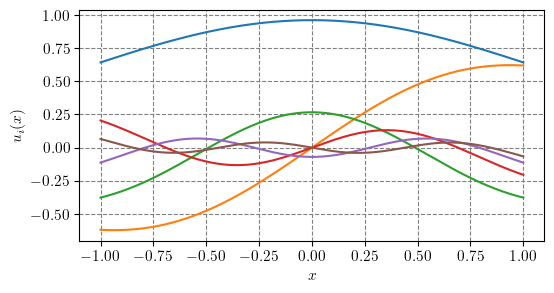

In [276]:
# random realization
n = exp_eigenvectors_functions.shape[1]

for i in range(3):
    realisation = np.random.normal(size=n)
    realisation = exp_eigenvectors_functions @ realisation

    plt.plot(x_axis, realisation)

plt.xlabel('x')
plt.ylabel('f(x)')
plt.savefig("1Drealization.pdf", bbox_inches='tight')
plt.show()

# eigenfunctions visualization
for i in range(1,7):
    plt.plot(x_axis, exp_eigenvectors_functions.T[-i])
#plt.title('Eigenfunctions')
plt.xlabel('$x$')
plt.ylabel(r'$u_{i}(x)\sqrt{\lambda_{i}}$')
plt.savefig("eigenfunctions.pdf", bbox_inches='tight')
plt.show()

# eigenfunctions visualization
for i in range(1,7):
    plt.plot(x_axis, sqexp_eigenvectors_functions.T[-i])
#plt.title('Eigenfunctions')
plt.xlabel('$x$')
plt.ylabel('$u_i(x)$')
plt.show()

# eigenfunctions visualization
for i in range(1,7):
    plt.plot(x_axis, mat_eigenvectors_functions.T[-i])
#plt.title('Eigenfunctions')
plt.xlabel('$x$')
plt.ylabel('$u_i(x)$')
plt.show()

In [200]:
def KL_exp_1D(L, nu, sigma_squared, N):
    """
    First N eigenpairs of the exponential kernel CY(x,y)=sigma_squared·exp(-|x-y|/nu) on [0,L].

    Returns
    -------
    lambdas: (N,) ndarray         # eigenvalues k_n  (Eq. A.8)
    f      : list of callables    # eigenfunctions f_n(x) (Eqs. A.5, A.10)
    """
    # characteristic eq. (g²w²−1)sin(wL)=2gw cos(wL)  — Eq. A.7
    ce = lambda w: (nu**2 * w**2 - 1) * np.sin(w * L) - 2 * nu * w * np.cos(w * L)

    w, n, eps = [], 1, 1e-12  # positive roots w_n
    for n in range(1, N + 1):
        a, b = (n - 1) * np.pi / L + eps, n * np.pi / L - eps    # bracket ( (n-1)π/L , nπ/L )
        w.append(brentq(ce, a, b))
    
    w = np.asarray(w)
    lambdas = 2 * nu * sigma_squared / (nu**2 * w**2 + 1.0)          # Eq. A.8
    b = 1 / np.sqrt((nu**2 * w**2 + 1) * L / 2 + nu)           # Eq. A.10
    a = nu * w * b

    # vectorised eigenfunction handles f_n(x)=a_n cos(w_n x)+b_n sin(w_n x)
    f = [(lambda a_, b_, w_: (lambda x, a=a_, b=b_, w=w_: a * np.cos(w * x) + b * np.sin(w * x)))
         (ai, bi, wi) for ai, bi, wi in zip(a, b, w)]
    return lambdas, f
analitic_eigenfunc = KL_exp_1D(2, 1, 1, 21)[1]

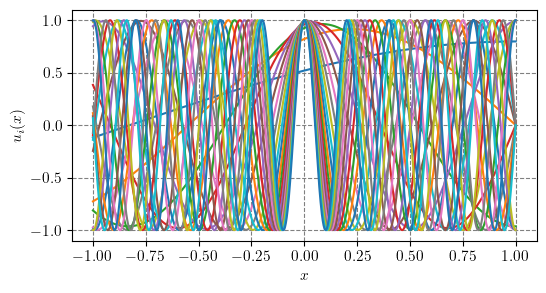

In [201]:
x_axis = np.linspace(-1, 1, 1000)
for fnc in analitic_eigenfunc:
    plt.plot(x_axis,fnc(x_axis))
plt.xlabel('$x$')
plt.ylabel('$u_i(x)$')
plt.show()

### Residuum:

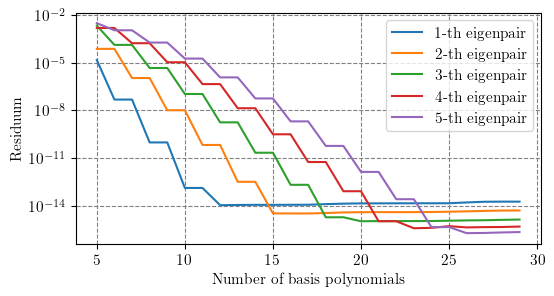

In [248]:
cov = lambda x,y : np.exp(-np.abs(x-y))


for i in range(5):
    residuum_i = []
    node_range=range(5,30)
    for n in node_range:
        l = lambda x : kl.integ.legendre_normal(x, n)
                
        nodes, weights = kl.integ.nodes_weights(1000)
        nodesx, nodesy = np.meshgrid(nodes,nodes)

        values = l(nodes)

        A = (values * weights)
        C = cov(nodesx, nodesy)
        matrix = A @ C @ A.T

        eigenvalues, eigenvectors = np.linalg.eigh(matrix)
        sort_idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sort_idx]
        eigenvectors = eigenvectors[:, sort_idx]

        #print(values.T.shape, eigenvectors.shape, matrix.shape)
        eigenvectors_functions = (values.T @ eigenvectors) * np.sqrt(np.maximum(eigenvalues, 0))
        
        eigf = eigenvectors_functions.T[i]
        eigv = eigenvalues[i]

        left_side = C@(eigf*weights)
        right_side = -eigv*eigf
        
        residuum_i.append(np.sqrt(weights @ ((left_side + right_side)**2)))

    plt.plot(node_range,residuum_i, label=f'{i+1}-th eigenpair')
plt.xlabel("Number of basis polynomials")
plt.ylabel("Residuum")
plt.legend()
plt.yscale("log")
plt.savefig("EigenpairsResiduum.pdf", bbox_inches='tight')
plt.show()

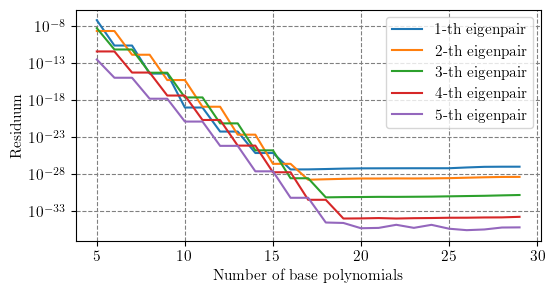

In [235]:
cov = lambda x,y : np.exp(-(np.abs(x-y))**2 / 2)

for i in range(5):
    residuum_i = []
    node_range=range(5,30)
    for n in node_range:
        l = lambda x : kl.integ.legendre_normal(x, n)
                
        nodes, weights = kl.integ.nodes_weights(1000)
        nodesx, nodesy = np.meshgrid(nodes,nodes)

        values = l(nodes)

        A = (values * weights)
        C = cov(nodesx, nodesy)
        matrix = A @ C @ A.T

        eigenvalues, eigenvectors = np.linalg.eigh(matrix)
        sort_idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sort_idx]
        eigenvectors = eigenvectors[:, sort_idx]

        #print(values.T.shape, eigenvectors.shape, matrix.shape)
        eigenvectors_functions = (values.T @ eigenvectors) * np.sqrt(np.maximum(eigenvalues, 0))
        
        eigf = eigenvectors_functions.T[i]
        eigv = eigenvalues[i]

        left_side = C@(eigf*weights)
        right_side = -eigv*eigf
        
        residuum_i.append(np.sqrt(weights @ ((left_side + right_side)**2)))

    plt.plot(node_range,residuum_i, label=f'{i+1}-th eigenpair')
plt.xlabel("Number of base polynomials")
plt.ylabel("Residuum")
plt.legend()
plt.yscale("log")
#plt.savefig("EigenpairsResiduum.pdf", bbox_inches='tight')
plt.show()

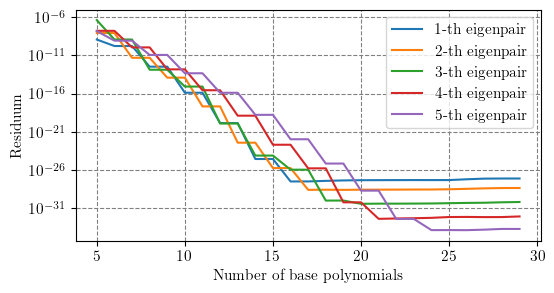

In [236]:
cov = lambda x,y : matern_covariance(np.abs(x-y), length_scale, variance, 2.5)

for i in range(5):
    residuum_i = []
    node_range=range(5,30)
    for n in node_range:
        l = lambda x : kl.integ.legendre_normal(x, n)
                
        nodes, weights = kl.integ.nodes_weights(1000)
        nodesx, nodesy = np.meshgrid(nodes,nodes)

        values = l(nodes)

        A = (values * weights)
        C = cov(nodesx, nodesy)
        matrix = A @ C @ A.T

        eigenvalues, eigenvectors = np.linalg.eigh(matrix)
        sort_idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sort_idx]
        eigenvectors = eigenvectors[:, sort_idx]

        #print(values.T.shape, eigenvectors.shape, matrix.shape)
        eigenvectors_functions = (values.T @ eigenvectors) * np.sqrt(np.maximum(eigenvalues, 0))
        
        eigf = eigenvectors_functions.T[i]
        eigv = eigenvalues[i]

        left_side = C@(eigf*weights)
        right_side = -eigv*eigf
        
        residuum_i.append(np.sqrt(weights @ ((left_side + right_side)**2)))

    plt.plot(node_range,residuum_i, label=f'{i+1}-th eigenpair')
plt.xlabel("Number of base polynomials")
plt.ylabel("Residuum")
plt.legend()
plt.yscale("log")
#plt.savefig("EigenpairsResiduum.pdf", bbox_inches='tight')
plt.show()

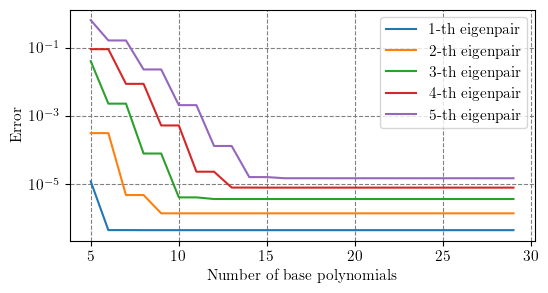

In [246]:
real_eigenvalues, analitic_eigenfunc = KL_exp_1D(2, 1, 1, 21)

cov = lambda x,y : np.exp(-np.abs(x-y))

for i in range(0,5):
    node_range=range(5,30)
    errors = []
    for n in node_range:
        l = lambda x : kl.integ.legendre_normal(x, n)
        
        nodes, weights = kl.integ.nodes_weights(1000)
        nodesx, nodesy = np.meshgrid(nodes,nodes)

        values = l(nodes)

        A = (values * weights)
        C = cov(nodesx, nodesy)
        matrix = A @ C @ A.T

        eigenvalues, eigenvectors = np.linalg.eigh(matrix)
        
        sort_idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sort_idx]
        eigenvectors = eigenvectors[:, sort_idx]


        #print(values.T.shape, eigenvectors.shape, matrix.shape)
        eigenvectors_functions = (values.T @ eigenvectors)
        
        real_eigenfunction = analitic_eigenfunc[i](nodes+1)
        eigf = eigenvectors_functions.T[i]
        errors.append(np.sqrt(weights @ ((eigf.flatten() - np.sign(eigf[0] * real_eigenfunction[1])* real_eigenfunction.flatten())**2)))

    plt.plot(node_range,errors, label=f'{i+1}-th eigenpair')
plt.xlabel("Number of base polynomials")
plt.ylabel("Error")
plt.legend()
plt.yscale("log")
plt.savefig("EigenpairsError.pdf", bbox_inches='tight')
plt.show()


#### Trying over <a,b>:

(21, 50)


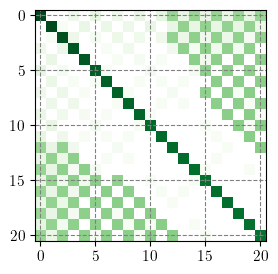

In [12]:
a = -2
b = 1
l = lambda x : kl.integ.legendre_normal(x, 20)
cov = lambda x,y : np.exp(-np.abs(x-y))

n = 50


nodes, weights = kl.integ.nodes_weights(n)

nodes = (a+b)/2 + (b-a)/2*nodes
weights = weights * (b-a)/2


nodesx, nodesy = np.meshgrid(nodes,nodes)
values = l((a+b)/(a-b) + (2/(b-a))*nodes)

#print(cov(nodesx, nodesy))
A = (values* weights)
matrix = A @ cov(nodesx, nodesy) @ A.T
#print(matrix)

#print(weights.shape)
#print(nodes.shape)
print(values.shape)
#print(cov(nodesx, nodesy).shape)
#print(matrix.shape)


# plot
fig, ax = plt.subplots()

#ax.imshow(matrix, cmap=colormaps['Greens'])
ax.imshow(matrix, cmap=colormaps['Greens'], norm=colors.LogNorm())
plt.show()

(21, 1000) (21,) (21, 21) (1000, 21)
(1000, 21) (21,)


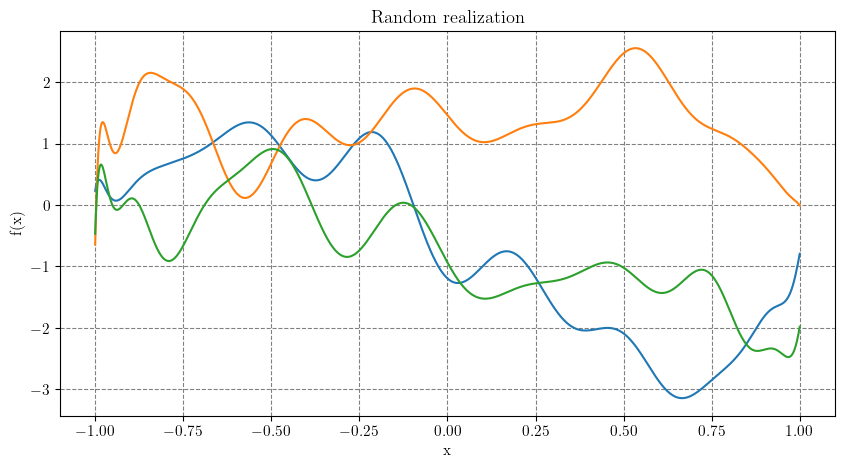

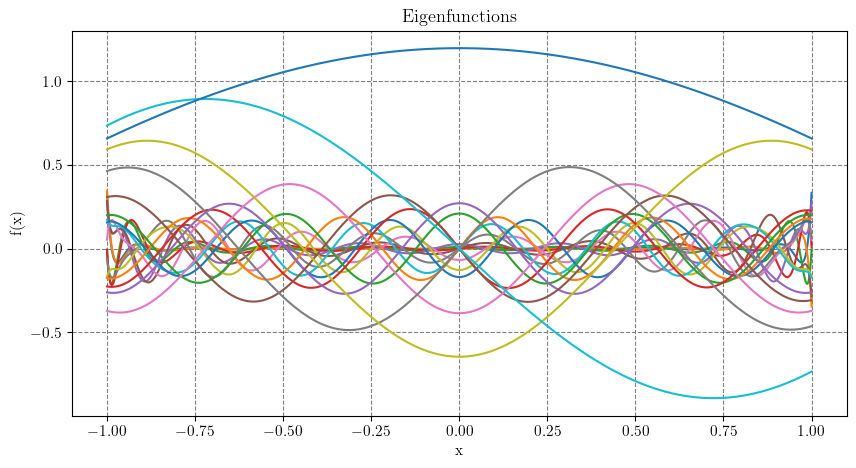

In [13]:
# eigendecomposition of matrix
eigenvalues, eigenvectors = np.linalg.eigh(matrix)
x_axis = np.linspace(-1, 1, 1000)
values = l(x_axis)
eigenvectors_functions = (values.T @ eigenvectors) * np.sqrt(np.maximum(eigenvalues, 0))
print(values.shape, eigenvalues.shape, eigenvectors.shape, eigenvectors_functions.shape)
print((values.T @ eigenvectors).shape, np.sqrt(np.maximum(eigenvalues, 0)).shape)

# random realization
n = eigenvectors_functions.shape[1]

plt.figure(figsize=(10, 5))
for i in range(3):
    realisation = np.random.normal(size=n)
    realisation = eigenvectors_functions @ realisation

    plt.plot(x_axis, realisation)


plt.title('Random realization')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()


# eigenfunctions visualization
plt.figure(figsize=(10, 5))
for fnc in eigenvectors_functions.T:
    plt.plot(x_axis, fnc)
plt.title('Eigenfunctions')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

---
## 2D

Obtaining a 4D tensor A and making it into 2D tensor

In [294]:
poly_count = 18
l = lambda x: kl.integ.legendre_normal(x, poly_count)
#cov = lambda x1, x2, y1, y2 : np.exp(-np.abs( np.sqrt( (x1-x2)**2+(y1-y2)**2 )))

n = 100


nodes, weights = kl.integ.nodes_weights(n)

#nodesx1, nodesx2, nodesy1, nodesy2 = np.meshgrid(nodes, nodes, nodes, nodes)
nodesx1 = np.reshape(nodes, (-1, 1, 1, 1))
nodesy1 = np.reshape(nodes, (1, -1, 1, 1))
nodesx2 = np.reshape(nodes, (1, 1, -1, 1))
nodesy2 = np.reshape(nodes, (1, 1, 1, -1))
values = l(nodes)

#print(cov(nodesx1, nodesx2, nodesy1, nodesy2).shape)
#print(values.shape)
dist_sq = (nodesx1 - nodesx2)**2 + (nodesy1 - nodesy2)**2
lamb = 10
C_tensor = np.exp(-np.sqrt(dist_sq)/lamb)


#matrix = (values* weights) @ cov(nodesx1, nodesx2, nodesy1, nodesy2) @ (values.T * weights[:, np.newaxis])
PW = (values* weights)
A_tensor = np.einsum('kp,lq,pqrs,ir,js->klij', PW, PW, C_tensor, PW, PW, optimize=True)
A_tensor.shape
A_matrix = np.reshape(A_tensor, ((poly_count+1)**2,(poly_count+1)**2))

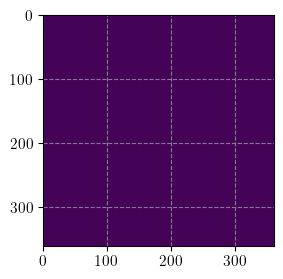

In [295]:
plt.imshow(A_matrix)

Making eigenfunctions (inefficient):

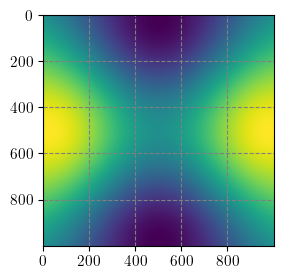

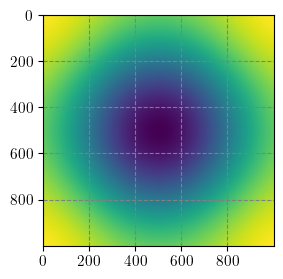

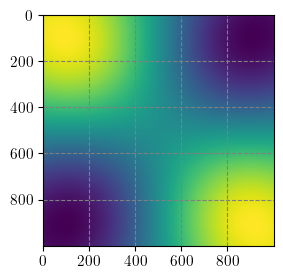

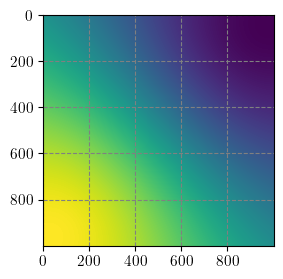

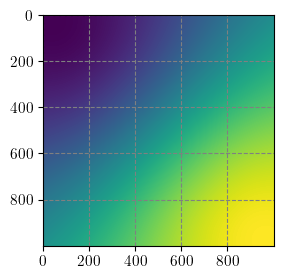

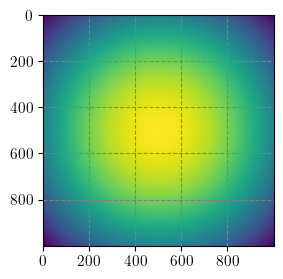

In [16]:
eigenvalues, eigenvectors = np.linalg.eigh(A_matrix)
#A = 1
#print((eigenvalues[A] * eigenvectors[:,A])- (A_matrix @ eigenvectors[:,A]))
x_axis = np.linspace(-1, 1, 1000)
values = l(x_axis)
for eivec in range((poly_count+1)**2-6,(poly_count+1)**2):
    sum = 0
    for i in range(len(values)):
        for j in range(len(values)):
            sum+=values[i]*values[j][:, np.newaxis]*eigenvectors[i*(poly_count+1)+j,eivec] *np.sqrt(np.maximum(eigenvalues[eivec], 0))
    plt.imshow(sum)
    plt.show()



Making eigenfunctions:

In [326]:
eigenvalues, eigenvectors = np.linalg.eigh(A_matrix)
#A = 1
#print((eigenvalues[A] * eigenvectors[:,A])- (A_matrix @ eigenvectors[:,A]))
x_axis = np.linspace(-1, 1, 200)
values = l(x_axis)

# Perform broadcasted multiplication
V1 = values[:, np.newaxis, np.newaxis, :] # Shape (L, 1, 1, N)
V2 = values[np.newaxis, :, :, np.newaxis] # Shape (1, L, N, 1)
V = V1 * V2
V = np.reshape(V, (len(V)**2,len(x_axis),len(x_axis)))
#print(V.shape)
eigenvectors_functions = (np.einsum('ijk,in->njk', V, eigenvectors, optimize=True).T * np.sqrt(np.maximum(eigenvalues, 0))).T
    

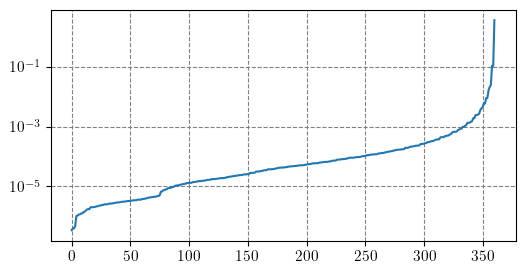

In [327]:
plt.plot(eigenvalues)
plt.yscale('log')
plt.show()

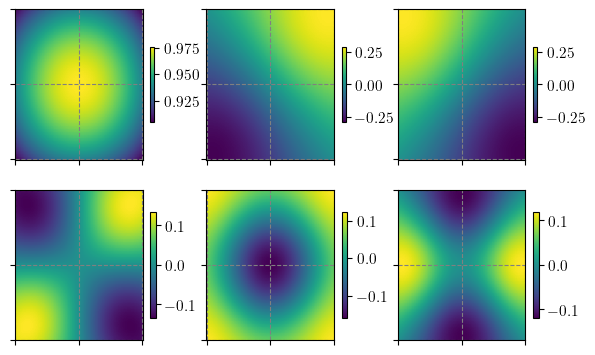

In [338]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4.3))
fig.subplots_adjust(wspace=0.2)
for i in range(6):
    if(i<3): 
        mesh= axs[0,i].pcolormesh(x_axis, x_axis, eigenvectors_functions[-i-1])
        axs[0,i].set_xticklabels([])
        axs[0,i].set_yticklabels([])
        axs[0,i].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[0,i].yaxis.set_major_locator(MaxNLocator(integer=True))
        fig.colorbar(mesh, ax=axs[0,i], shrink=0.5)
    else:
        mesh= axs[1,i-3].pcolormesh(x_axis, x_axis, eigenvectors_functions[-i-1])
        axs[1,i-3].set_xticklabels([])
        axs[1,i-3].set_yticklabels([])
        axs[1,i-3].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1,i-3].yaxis.set_major_locator(MaxNLocator(integer=True))
        fig.colorbar(mesh, ax=axs[1,i-3], shrink=0.7)

plt.savefig("Eigenfunctions2D.pdf", bbox_inches='tight')
plt.show()

minimal value: -0.29158680808978105
maximal value: 0.9759005444013589
value interval size: 1.2674873524911399


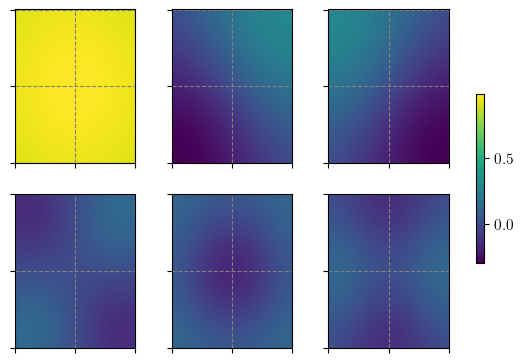

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(8, 4.4))
fig.subplots_adjust(wspace=0.3)


vmin_global = min(data.min() for data in eigenvectors_functions[-6:])
vmax_global = max(data.max() for data in eigenvectors_functions[-6:])

print("minimal value:", vmin_global)
print("maximal value:", vmax_global)
print("value interval size:", vmax_global-vmin_global)

for i in range(6):
    if(i<3): 
        mesh = axs[0,i].pcolormesh(x_axis, x_axis, eigenvectors_functions[-i-1], vmin=vmin_global, vmax=vmax_global)
        axs[0,i].set_xticklabels([])
        axs[0,i].set_yticklabels([])
        axs[0,i].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[0,i].yaxis.set_major_locator(MaxNLocator(integer=True))
    else:
        mesh = axs[1,i-3].pcolormesh(x_axis, x_axis, eigenvectors_functions[-i-1], vmin=vmin_global, vmax=vmax_global)
        axs[1,i-3].set_xticklabels([])
        axs[1,i-3].set_yticklabels([])
        axs[1,i-3].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1,i-3].yaxis.set_major_locator(MaxNLocator(integer=True))

fig.colorbar(mesh, ax=axs, location='right', shrink=0.5)
#plt.savefig("Eigenfunctions2D.pdf", bbox_inches='tight')
plt.show()

Random fields samples:

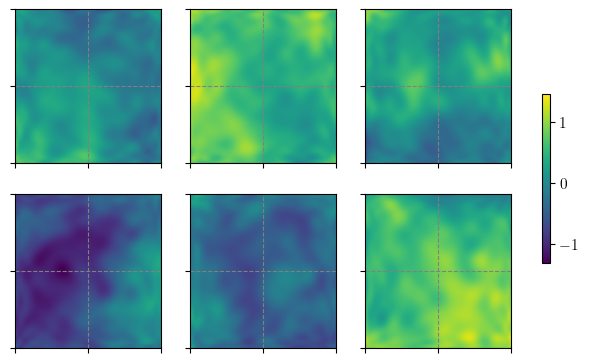

In [317]:
# random realization
n = eigenvectors_functions.shape[0]

all_realizations = []
fig, axs = plt.subplots(2, 3, figsize=(8, 4.4))
for i in range(6):
    realisation = np.random.normal(size=n)
    #print(realisation.shape)
    #print(eigenvectors_functions.T.shape)
    realisation = eigenvectors_functions.T @ realisation
    all_realizations.append(realisation)

vmin_global = min(data.min() for data in all_realizations)
vmax_global = max(data.max() for data in all_realizations)

print("minimal value:", vmin_global)
print("maximal value:", vmax_global)
print("value interval size:", vmax_global-vmin_global)

for i in range(6):
    realisation = all_realizations[i]
    if(i<3): 
        mesh = axs[0,i].pcolormesh(x_axis, x_axis, realisation, vmin=vmin_global, vmax=vmax_global)
        axs[0,i].set_xticklabels([])
        axs[0,i].set_yticklabels([])
        axs[0,i].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[0,i].yaxis.set_major_locator(MaxNLocator(integer=True))
    else:
        mesh = axs[1,i-3].pcolormesh(x_axis, x_axis, realisation, vmin=vmin_global, vmax=vmax_global)
        axs[1,i-3].set_xticklabels([])
        axs[1,i-3].set_yticklabels([])
        axs[1,i-3].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1,i-3].yaxis.set_major_locator(MaxNLocator(integer=True))

fig.colorbar(mesh, ax=axs, location='right', shrink=0.5)

fig.savefig("2DRealization.pdf", bbox_inches='tight')
plt.show()
#
#
#plt.title('Random realization')
#plt.xlabel('x')
#plt.ylabel('f(x)')

Global vmin: -1.49
Global vmax: 3.49


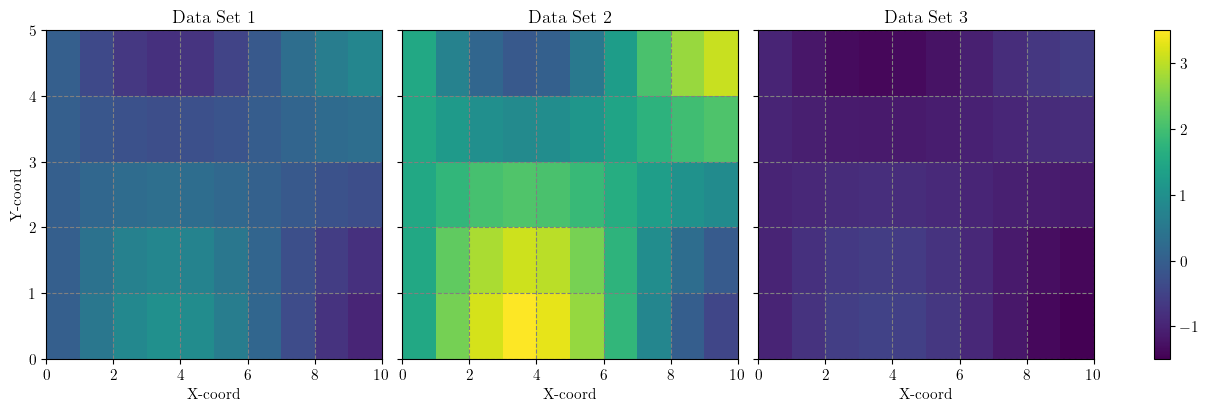

In [308]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Example Data ---
# Create coordinate grids (can be the same for all plots if applicable)
x = np.arange(0, 11, 1)
y = np.arange(0, 6, 1)
X, Y = np.meshgrid(x, y)

# Create multiple data arrays (Z) with DIFFERENT ranges
Z1 = np.sin(X[:-1, :-1] * 0.5) * np.cos(Y[:-1, :-1] * np.pi / 5)  # Range approx -1 to 1
Z2 = Z1 * 2 + 1.5                                                # Range approx -0.5 to 3.5
Z3 = Z1 * 0.5 - 1.0                                              # Range approx -1.5 to -0.5

# Store the data arrays together
all_data = [Z1, Z2, Z3]
titles = ['Data Set 1', 'Data Set 2', 'Data Set 3']

# --- 2. Find Global Min and Max ---
vmin_global = min(data.min() for data in all_data)
vmax_global = max(data.max() for data in all_data)

print(f"Global vmin: {vmin_global:.2f}")
print(f"Global vmax: {vmax_global:.2f}")

# --- 3. Create Subplots ---
# Adjust nrows/ncols based on how many plots you have
nrows = 1
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 4), sharey=True, constrained_layout=True)
# Use constrained_layout=True for better automatic spacing

# Choose a colormap
cmap = 'viridis'

# Store one of the mappable objects for the colorbar
mappable = None

# --- 4. Plot Each Dataset with Shared vmin/vmax ---
# Flatten axs if necessary (e.g., if nrows=1 or ncols=1)
if nrows == 1 and ncols > 1:
    axs_flat = axs
elif ncols == 1 and nrows > 1:
    axs_flat = axs
else:
    axs_flat = axs.flatten()


for i, ax in enumerate(axs_flat):
    if i < len(all_data):
        data_to_plot = all_data[i]
        # IMPORTANT: Set vmin and vmax in pcolormesh
        mesh = ax.pcolormesh(X, Y, data_to_plot,
                              cmap=cmap,
                              shading='flat',
                              vmin=vmin_global,
                              vmax=vmax_global)
        if mappable is None: # Store the first mesh object
            mappable = mesh

        ax.set_title(titles[i])
        ax.set_xlabel('X-coord')
        if i == 0: # Only set y-label for the first plot if sharing y-axis
            ax.set_ylabel('Y-coord')
    else:
        ax.axis('off') # Hide unused axes if any

    cbar = fig.colorbar(mappable, ax=axs, # Link to all axes for layout
                        shrink=0.7,      # Adjust size/position as needed
                        location='right' # Or 'bottom', 'top', 'left'
                        )
    cbar.set_label('Shared Color Scale Value')


# Add an overall title (optional)
# fig.suptitle("Multiple Plots with Shared Color Scale") # Use if constrained_layout=False

plt.show()

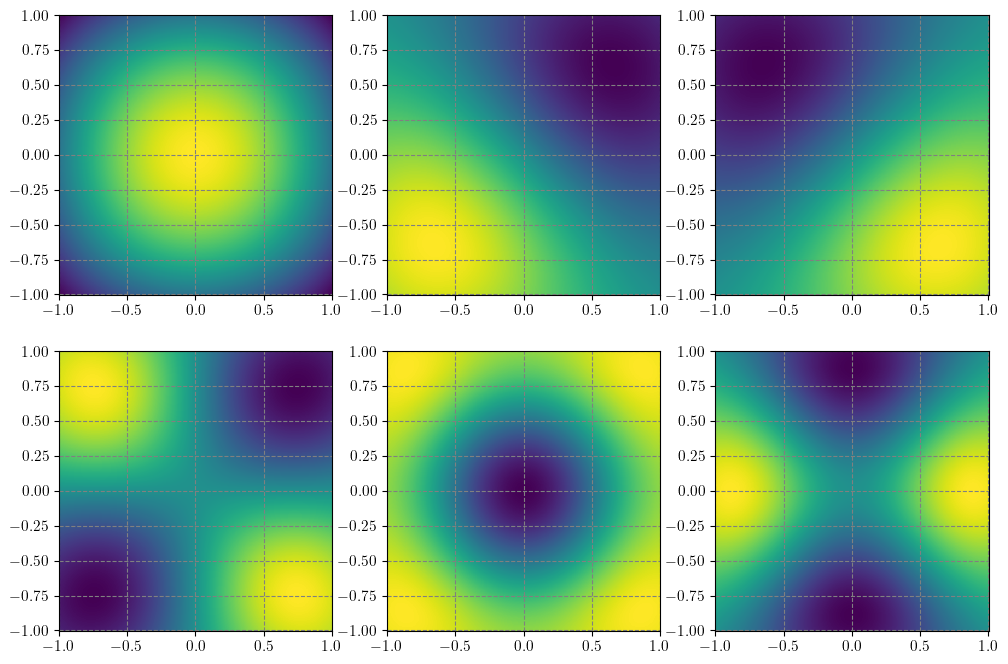

In [21]:
x = np.linspace(-1, 1, 500)


def C(x1,x2,y1,y2):
    dist_sq = (x1 - x2)**2 + (y1 - y2)**2
    return np.exp(-np.sqrt(dist_sq))
eigenfunctions = kl.get_eigenfuntions(x, C, 30, 80)
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i in range(6):
    if(i<3): 
        axs[0,i].pcolormesh(x, x, eigenfunctions[-i-1])
    else:
        axs[1,i-3].pcolormesh(x, x, eigenfunctions[-i-1])
plt.show()

<Figure size 1000x500 with 0 Axes>

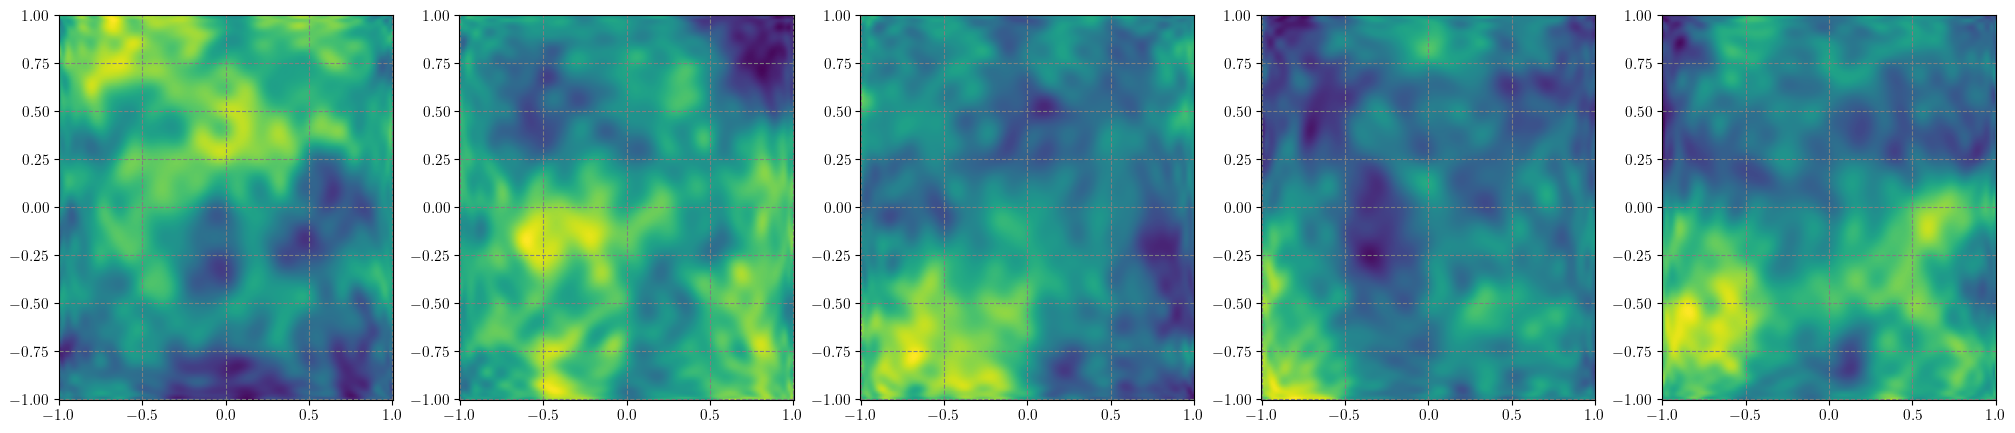

In [22]:
n = eigenfunctions.shape[0]

plt.figure(figsize=(10, 5))

fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i in range(5):
    realisation = kl.sample_normal(eigenfunctions)

    axs[i].pcolormesh(x, x, realisation)
    
plt.show()

Lets see how of the integrals of same polynomials with a C_tensor look like as graphs

In [23]:
l = lambda x : kl.integ.legendre_normal(x, 100)

In [24]:
n = 10

lamb = 10
aprox = []
node_range = range(20,100)
#node_range = range(1,n+20)
for node_count in node_range:
    nodes, weights = kl.integ.nodes_weights(node_count)
    nodesx = np.reshape(nodes, (-1, 1))
    nodesy = np.reshape(nodes, (1, -1))
    dist_sq = (nodesx)**2 + (nodesy)**2
    C_tensor = np.exp(-np.sqrt(dist_sq)/lamb)
    #int_aprox = np.einsum('j,jk,k->', l(nodes)[n], C_tensor, l(nodes)[n])
    int_aprox =(l(nodes)[n]*weights) @ C_tensor @ (l(nodes)[n]*weights)
    aprox.append(int_aprox)

Integral result:

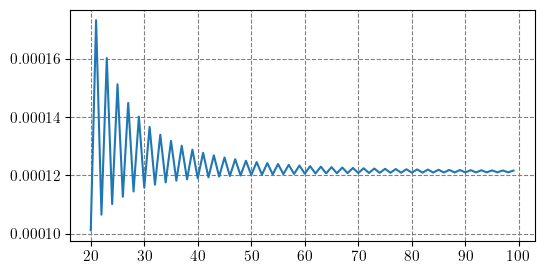

In [25]:
plt.plot(node_range,aprox)
plt.show()

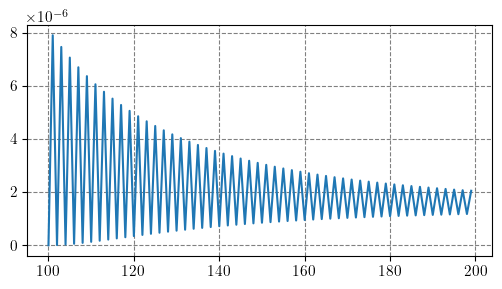

In [26]:
n = 100

lamb = 1
aprox = []
node_range = range(100,200)
#node_range = range(250,300)
for node_count in node_range:
    nodes, weights = kl.integ.nodes_weights(node_count)
    nodesx = np.reshape(nodes, (-1, 1))
    nodesy = np.reshape(nodes, (1, -1))
    dist_sq = (nodesx)**2 + (nodesy)**2
    C_tensor = np.exp(-np.sqrt(dist_sq)/lamb)
    #int_aprox = np.einsum('j,jk,k->', l(nodes)[n], C_tensor, l(nodes)[n])
    int_aprox =(l(nodes)[n]*weights) @ C_tensor @ (l(nodes)[n]*weights)
    aprox.append(int_aprox)
plt.plot(node_range,aprox)
plt.show()

### Lets have a different C

In [27]:
n = 4

lamb = 1
aprox = []
difference = []
node_range = range(15,100)
#node_range = range(1,n+20)
for node_count in node_range:
    nodes, weights = kl.integ.nodes_weights(node_count)
    nodesx = np.reshape(nodes, (-1, 1))
    nodesy = np.reshape(nodes, (1, -1))
    dist_sq = (nodesx)**2 + (nodesy)**2
    C_tensor = np.exp(-dist_sq/lamb)
    #int_aprox = np.einsum('j,jk,k->', l(nodes)[n], C_tensor, l(nodes)[n])
    int_aprox =(l(nodes)[n]*weights) @ C_tensor @ (l(nodes)[n]*weights)
    aprox.append(int_aprox)
    difference.append(np.abs(int_aprox-0.0164274897245295915177756431842263468086376299790787366359421403395269788))

Integral result:

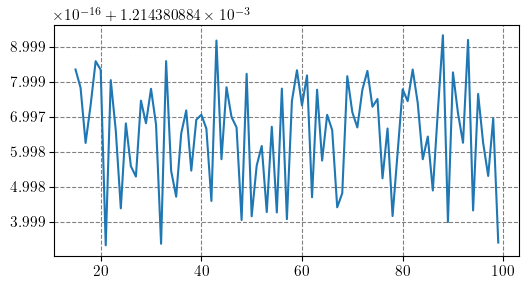

In [28]:
plt.plot(node_range,aprox)
plt.show()

Difference from real value:

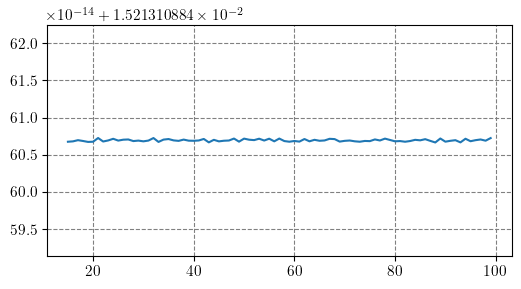

In [29]:
plt.plot(node_range,difference)
plt.show()

In [30]:
n = 4

lamb = 1
aprox = []
difference = []
times = []
node_range = range(15,500)
#node_range = range(1,n+20)
for node_count in node_range:
    starttime = time.time()
    nodes, weights = kl.integ.nodes_weights(node_count)
    dist_sq = (nodes)**2
    C_tensor = np.exp(-dist_sq/lamb)
    #int_aprox = np.einsum('j,jk,k->', l(nodes)[n], C_tensor, l(nodes)[n])
    int_aprox =((l(nodes)[n]*weights) @ C_tensor)**2
    endtime = time.time()

    aprox.append(int_aprox)
    difference.append(np.abs(int_aprox-0.0164274897245295915177756431842263468086376299790787366359421403395269788))
    times.append(endtime-starttime)


Integral result:

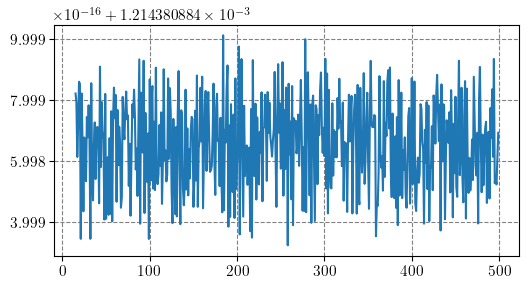

In [31]:
plt.plot(node_range,aprox)
plt.show()

Difference from real value:

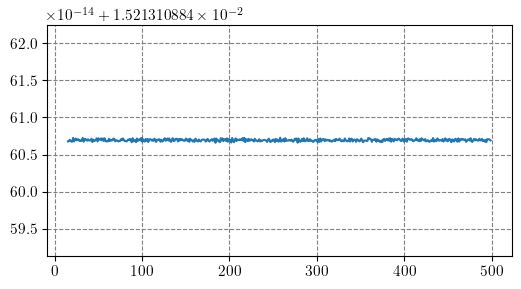

In [32]:
plt.plot(node_range,difference)
plt.show()

Time graph

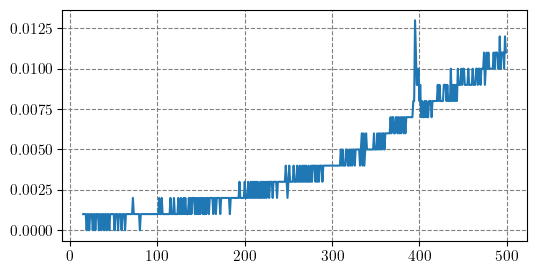

In [33]:
plt.plot(node_range,times)
plt.show()